In [73]:
import os
import re
import math
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from glob import glob
from tools.settings import *
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tools.train_val_test_spliter import split
import collections
from collections import Counter

In [ ]:
split()

In [2]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))
print(train.shape)
print(test.shape)
print(val.shape)

(343, 2)
(113, 2)
(113, 2)


In [ ]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [ ]:
convert_to_frame(train, train_frames_path_name)

In [ ]:
convert_to_frame(val, val_frames_path_name)

In [ ]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [ ]:
create_paths_csv(train_frames_path, train_frames_path_name)

In [ ]:
create_paths_csv(val_frames_path, val_frames_path_name)

In [3]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image

,image,action
0,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
1,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
2,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
3,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
4,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
...,...,...
1264,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
1265,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
1266,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
1267,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction


In [4]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image

,image,action
0,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
1,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
2,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
3,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
4,F:/Personal/CSGO-Video-Analysis/Video Analysis...,death
...,...,...
421,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
422,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
423,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction
424,F:/Personal/CSGO-Video-Analysis/Video Analysis...,NoAction


In [5]:
action_values = list(train_image['action'].unique())
action_values

['death', 'kill', 'NoAction', 'smoke']

In [6]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [7]:
create_class_columns(train_image)
train_image.head()

,image,death,kill,NoAction,smoke
0,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
1,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
2,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
3,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
4,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0


In [8]:
create_class_columns(val_image)
val_image.head()

,image,death,kill,NoAction,smoke
0,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
1,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
2,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
3,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0
4,F:/Personal/CSGO-Video-Analysis/Video Analysis...,1,0,0,0


In [9]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(227,227,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

In [10]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:07<00:00, 166.22it/s]


(1269, 227, 227, 3)


In [11]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 426/426 [00:02<00:00, 159.41it/s]

(426, 227, 227, 3)


In [12]:
X_train_copy, y_train_copy=X_train,y_train
X_val_copy, y_val_copy=X_val,y_val

In [123]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(64, (5,5), input_shape=(227,227,3), strides=(2,2), padding="valid", activation = "relu"))
# Max Pooling 1
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# 2nd Convolutional Layer
model.add(Conv2D(64, (1,1), strides=(1,1), padding="same", activation = "relu"))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3,3), strides=(1,1), padding="same", activation = "relu"))
# Max Pooling 2
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))

#NOT NEEDED
model.add(Dropout(0.5))
#Parallel convolution 1


# Max Pooling 3
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))

#Parallel convolution 2

#Parallel convolution 3

# Max Pooling 4
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))

#Parallel convolution 4

# Max Pooling 5
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))

#NOT NEEDED
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(512, activation = "relu"))

#NOT NEEDED
model.add(Dropout(0.5))

# 2nd Fully Connected Layer
model.add(Dense(4, activation = "softmax"))
model.summary()

model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001),metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('CYNNET.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 112, 112, 64)      4864      
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 55, 55, 64)        4160      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 27, 27, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 27, 27, 128)       0         
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 13, 13, 128)     

In [124]:
history=model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=16)

Epoch 1/60
80/80 [==============================] - 3s 33ms/step - loss: 1.3669 - accuracy: 0.3010 - val_loss: 1.3480 - val_accuracy: 0.3662
Epoch 2/60
80/80 [==============================] - 3s 31ms/step - loss: 1.3049 - accuracy: 0.3680 - val_loss: 1.3082 - val_accuracy: 0.3357
Epoch 3/60
80/80 [==============================] - 2s 30ms/step - loss: 1.2660 - accuracy: 0.4082 - val_loss: 1.2718 - val_accuracy: 0.4695
Epoch 4/60
80/80 [==============================] - 2s 29ms/step - loss: 1.1853 - accuracy: 0.5051 - val_loss: 1.2306 - val_accuracy: 0.5681
Epoch 5/60
80/80 [==============================] - 3s 32ms/step - loss: 1.1364 - accuracy: 0.5209 - val_loss: 1.1645 - val_accuracy: 0.6315
Epoch 6/60
80/80 [==============================] - 3s 32ms/step - loss: 1.0442 - accuracy: 0.5863 - val_loss: 1.1178 - val_accuracy: 0.6573
Epoch 7/60
80/80 [==============================] - 3s 33ms/step - loss: 0.9829 - accuracy: 0.6107 - val_loss: 1.0650 - val_accuracy: 0.6667
Epoch 8/60
80

Epoch 59/60
80/80 [==============================] - 2s 30ms/step - loss: 0.1701 - accuracy: 0.9496 - val_loss: 0.7994 - val_accuracy: 0.7042
Epoch 60/60
80/80 [==============================] - 2s 29ms/step - loss: 0.1590 - accuracy: 0.9535 - val_loss: 0.7679 - val_accuracy: 0.7042


In [125]:
model.load_weights("CYNNET.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 112, 112, 64)      4864      
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 55, 55, 64)        4160      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 27, 27, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 27, 27, 128)       0         
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 13, 13, 128)     

In [ ]:
from scipy import stats as s
predict_vgg16 = []
actual = []
dict_vgg16 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(227,227,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    prediction_images_copy = prediction_images
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    #prediction_images = base_model_vgg16.predict(prediction_images)
    # converting features in one dimensional array
    #prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_vgg16[video_name] = prediction_test
        #print(prediction_test)
        #print(action)
        #print(video_name)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_vgg16.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

  0%|                                                                                          | 0/113 [00:00<?, ?it/s]

In [122]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_vgg16, actual)*100

70.79646017699115

In [113]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_vgg16, actual)*100
precision = precision_score(actual, predict_vgg16, average=None)
f1_score = f1_score(actual, predict_vgg16, average=None)
recall = recall_score(actual, predict_vgg16, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  75.22123893805309
Precision:  [0.77777778 0.77777778 0.69230769 0.8       ]
F1_score:  [0.77777778 0.63636364 0.7826087  0.7804878 ]
Recall:  [0.77777778 0.53846154 0.9        0.76190476]


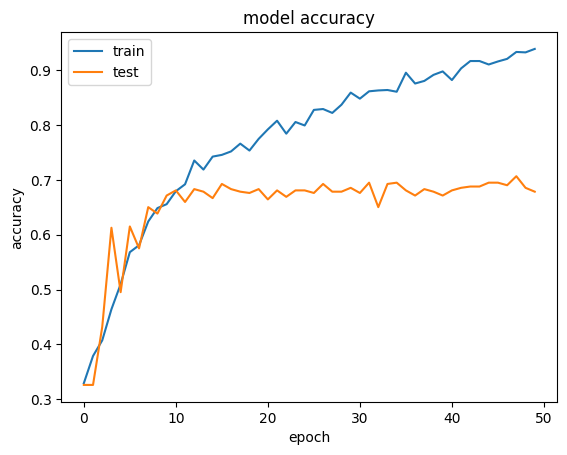

In [114]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

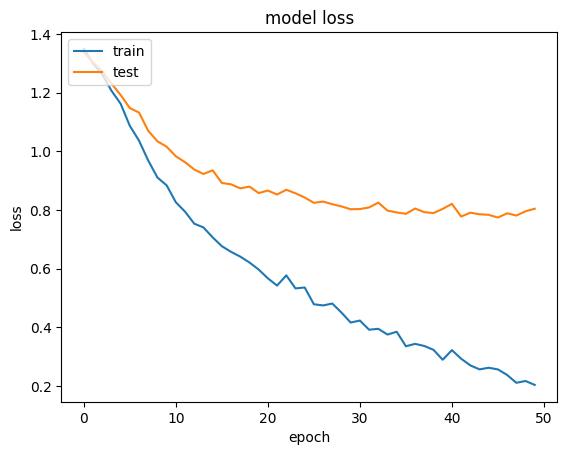

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2nd Model

In [24]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# 3rd Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
model.add(Dropout(0.5))
# 4th Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
'''
# 5th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
# 6th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
# 7th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
'''
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 1024, activation = "relu"))
# 2nd Fully Connected Layer
model.add(Dense(units = 512, activation = "relu"))
model.add(Dropout(0.5))
# 3rd Fully Connected Layer
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(4, activation = "softmax")) #As we have two classes
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 96)        221280    
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 96)       

In [41]:
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('New_Network.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [42]:
history=model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=150)

Epoch 1/40
9/9 [==============================] - 2s 185ms/step - loss: 1.4701 - accuracy: 0.2632 - val_loss: 1.3807 - val_accuracy: 0.2535
Epoch 2/40
9/9 [==============================] - 1s 161ms/step - loss: 1.3777 - accuracy: 0.3089 - val_loss: 1.3774 - val_accuracy: 0.3263
Epoch 3/40
9/9 [==============================] - 1s 157ms/step - loss: 1.3651 - accuracy: 0.3396 - val_loss: 1.3757 - val_accuracy: 0.3263
Epoch 4/40
9/9 [==============================] - 1s 161ms/step - loss: 1.3688 - accuracy: 0.3388 - val_loss: 1.3719 - val_accuracy: 0.3263
Epoch 5/40
9/9 [==============================] - 1s 157ms/step - loss: 1.3626 - accuracy: 0.3381 - val_loss: 1.3744 - val_accuracy: 0.3263
Epoch 6/40
9/9 [==============================] - 1s 159ms/step - loss: 1.3588 - accuracy: 0.3215 - val_loss: 1.3718 - val_accuracy: 0.3263
Epoch 7/40
9/9 [==============================] - 1s 157ms/step - loss: 1.3378 - accuracy: 0.3357 - val_loss: 1.3439 - val_accuracy: 0.3263
Epoch 8/40
9/9 [====

In [43]:
model.load_weights("New_Network.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 96)        221280    
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 96)       

In [44]:
from scipy import stats as s
predict_vgg16 = []
actual = []
dict_vgg16 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    prediction_images_copy = prediction_images
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    #prediction_images = base_model_vgg16.predict(prediction_images)
    # converting features in one dimensional array
    #prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_vgg16[video_name] = prediction_test
        #print(prediction_test)
        #print(action)
        #print(video_name)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_vgg16.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:57<00:00,  1.95it/s]


In [71]:
print(dict_vgg16)

{'smoke_86 ': 'NoAction', 'NoAction_73 ': 'kill', 'NoAction_2 ': 'kill', 'death_50 ': 'kill', 'kill_51 ': 'NoAction', 'NoAction_83 ': 'smoke', 'death_48 ': 'NoAction', 'death_41 ': 'NoAction', 'NoAction_128 ': 'kill', 'kill_35 ': 'NoAction', 'death_99 ': 'kill', 'death_106 ': 'kill', 'weapon_p2000_02': 'kill', 'death_123 ': 'kill', 'kill_79 ': 'NoAction', 'kill_103 ': 'NoAction', 'death_128 ': 'kill', 'death_4 ': 'smoke', 'death_53 ': 'kill', 'death_20 ': 'smoke', 'death_47 ': 'NoAction', 'NoAction_79 ': 'kill', 'death_116 ': 'kill', 'NoAction_92 ': 'smoke', 'death_36 ': 'NoAction', 'death_75 ': 'kill', 'kill_40 ': 'NoAction', 'NoAction_87 ': 'kill', 'kill_123 ': 'NoAction', 'smoke_97 ': 'kill', 'kill_87 ': 'NoAction', 'kill_59 ': 'NoAction', 'NoAction_77 ': 'smoke', 'smoke_39 ': 'kill', 'death_87 ': 'kill', 'smoke_8 ': 'kill', 'death_115 ': 'kill', 'NoAction_75 ': 'kill', 'kill_113 ': 'NoAction', 'death_24 ': 'kill', 'death_54 ': 'NoAction', 'NoAction_84 ': 'kill', 'kill_46 ': 'NoActi

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_vgg16, actual)*100

73.45132743362832

In [46]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_vgg16, actual)*100
precision = precision_score(actual, predict_vgg16, average=None)
f1_score = f1_score(actual, predict_vgg16, average=None)
recall = recall_score(actual, predict_vgg16, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  73.45132743362832
Precision:  [0.73684211 0.67857143 0.94444444 0.65517241]
F1_score:  [0.75675676 0.7037037  0.70833333 0.76      ]
Recall:  [0.77777778 0.73076923 0.56666667 0.9047619 ]


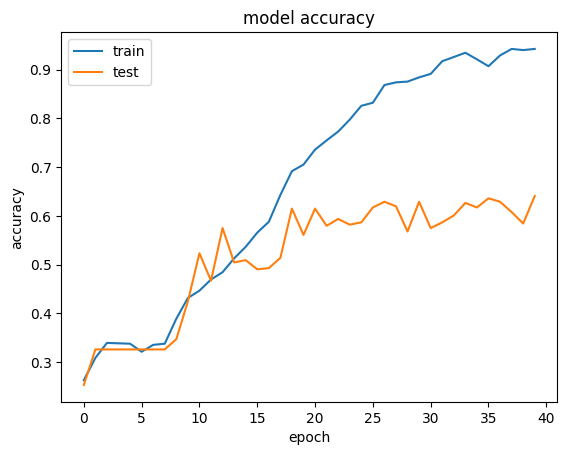

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

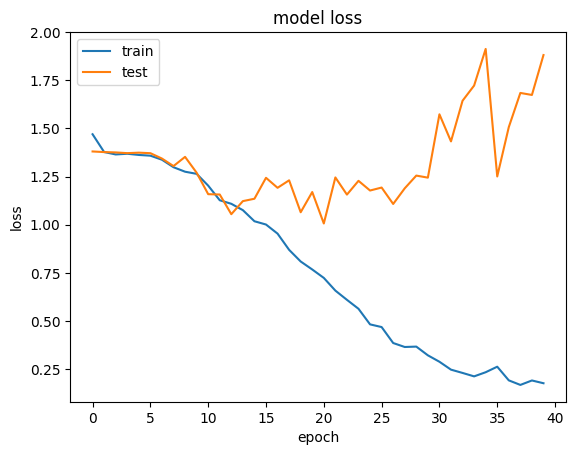

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)))    
model.add(Dropout(0.2))
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))
    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))    
    
model.add(Conv2D(192, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1),padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(10, (1, 1), padding='valid'))

# Output Layer
model.add(Dense(4, activation = "softmax")) 
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()